# CredCastle Experiments

## Import Stuff

In [223]:
import numpy as np

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor


## Initial Params

In [224]:
genesis_states = {
    'castle': 0, # the castle
    'difficulty': 100, # the difficulty of building the castle
    'village_population': 100 # the folks in the village
}

sim_config_dict = {
    'T': range(30), # 30 days
    'N': 1, # 1 month
    #'M': {}
}

## Policy Functions

In [225]:
def p_villager_effort(params, step, sH, s):
    villager_effort = np.random.randint(0, 10)
    return ({'villager_effort': villager_effort})

def p_working_villagers(params, step, sH, s):
    working_villagers = np.random.randint(0, s['village_population'])
    return ({'working_villagers': working_villagers})

## State Update Functions

In [226]:
def s_build_castle(params, step, sH, s, _input):
    y = 'castle'
    x = s[y]
    add_to_castle = round(_input['villager_effort'] * _input['working_villagers'] / s['difficulty'])
    x += add_to_castle
    return (y, x)

## State Update Blocks

In [227]:
partial_state_update_blocks = [
    { 
        'policies': { # We'll ignore policies for now
            'villager_effort': p_villager_effort,
            'working_villagers': p_working_villagers
        },
        'variables': { # The following state variables will be updated simultaneously
            'castle': s_build_castle
        }
    }
]

## Putting it all together

In [228]:
# imported some addition utilities to help with configuration set-up
exp = Experiment()
c = config_sim(sim_config_dict)

# The configurations above are then packaged into a `Configuration` object
del configs[:]
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

## Running the engine

In [229]:
%%capture
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=configs) # Pass the configuration object inside an array
raw_system_events, tensor_field, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

## Data Viz

In [230]:
%matplotlib inline
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

castle  difficulty  village_population  \
subset run timestep substep                                           
0      1   0        0             0         100                 100   
           1        1             0         100                 100   
           2        1             4         100                 100   
           3        1             4         100                 100   
           4        1            12         100                 100   
           5        1            14         100                 100   
           6        1            15         100                 100   
           7        1            17         100                 100   
           8        1            23         100                 100   
           9        1            28         100                 100   
           10       1            30         100                 100   
           11       1            32         100                 100   
           12       1            32         100                 100   
           13       1            32         100                 100   
           14       1            34         100                 100   
           15       1            38         100                 100   
           16       1            38         100                 100   
           17       1            38         100                 100   
           18       1            41         100                 100   
           19       1            42         100                 100   
           20       1            51         100                 100   
           21       1            51         100                 100   
           22       1            55         100                 100   
           23       1            55         100                 100   
           24       1            61         100                 100   
           25       1            61         100                 100   
           26       1            63         100                 100   
           27       1            63         100                 100   
           28       1            66         100                 100   
           29       1            66         100                 100   
           30       1            68         100                 100   

                             simulation  
subset run timestep substep              
0      1   0        0                 0  
           1        1                 0  
           2        1                 0  
           3        1                 0  
           4        1                 0  
           5        1                 0  
           6        1                 0  
           7        1                 0  
           8        1                 0  
           9        1                 0  
           10       1                 0  
           11       1                 0  
           12       1                 0  
           13       1                 0  
           14       1                 0  
           15       1                 0  
           16       1                 0  
           17       1                 0  
           18       1                 0  
           19       1                 0  
           20       1                 0  
           21       1                 0  
           22       1                 0  
           23       1                 0  
           24       1                 0  
           25       1                 0  
           26       1                 0  
           27       1                 0  
           28       1                 0  
           29       1                 0  
           30       1                 0

<AxesSubplot:xlabel='timestep'>

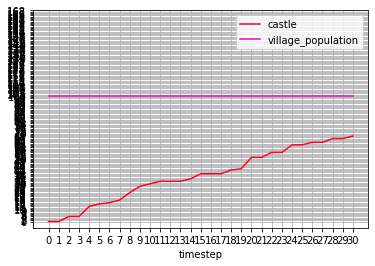

In [231]:
simulation_result.plot('timestep', ['castle', 'village_population'], grid=True, 
        colormap = 'gist_rainbow',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['castle']+simulation_result['village_population']).max())))